<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/LinearSVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Goal: Predict the price of crude palm oil using support vector regression (SVR)

###Load the Libraries

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler

###Define Functions to Facilitate Metrics Evaluation

In [139]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [140]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [141]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [142]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

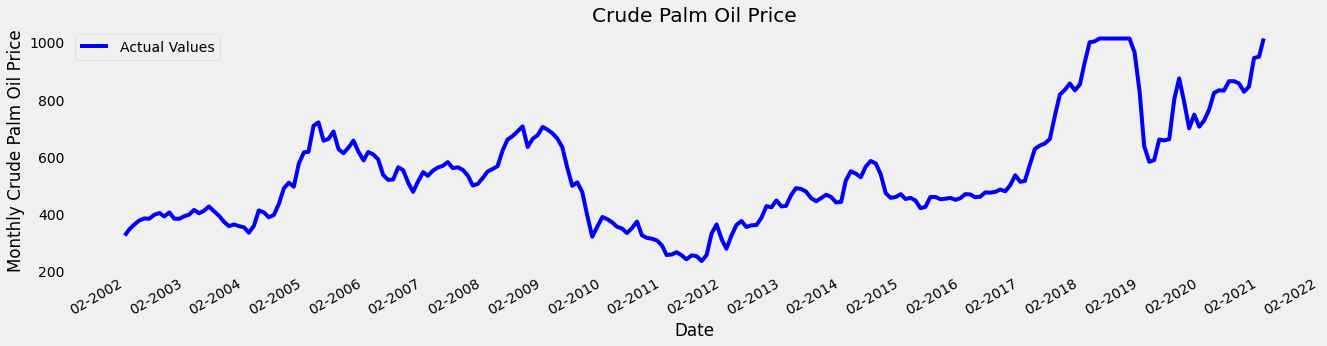

In [143]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [144]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

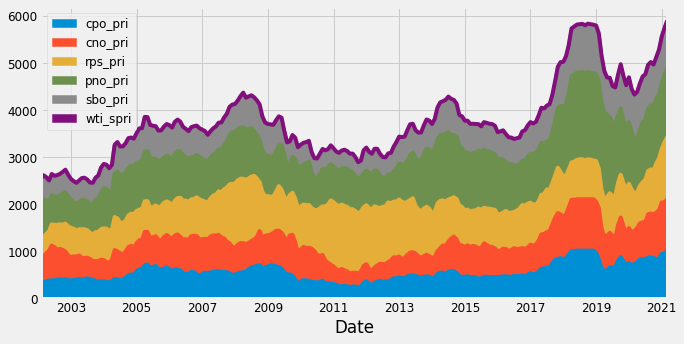

In [145]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Linear Support Vector Regression (LinearSVR)**

###**Split Data into Train Test Segments**

In [146]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [147]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [148]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [149]:
f_transformer = RobustScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,-0.646119,-1.324544,-0.231262,-0.442244,-0.717978
2002-03-01,345.0,-0.230594,-1.348516,-0.395149,-0.338987,-0.856057
2002-04-01,362.0,-0.006849,-1.364539,-0.690145,-0.454392,-0.936328
2002-05-01,376.0,0.180365,-1.351764,-1.068905,-0.600167,-0.950202
2002-06-01,383.0,0.646119,-1.237519,-1.050696,-0.679128,-0.928400


In [150]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.801187
2002-03-01   -0.670623
2002-04-01   -0.569733
2002-05-01   -0.486647
2002-06-01   -0.445104
Name: cpo_pri, dtype: float64

In [151]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.614155,0.012901,0.597786,0.950695,-0.031877
2017-07-01,645.0,0.760274,0.197485,0.396351,1.058264,-0.007763
2017-08-01,661.0,0.787671,0.100871,0.537949,1.082499,-0.131968
2017-09-01,743.0,1.057078,0.093017,0.621567,1.293083,-0.091007
2017-10-01,816.0,1.358447,0.169917,0.953857,1.505672,-0.215212


In [152]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    1.068249
2017-07-01    1.109792
2017-08-01    1.204748
2017-09-01    1.691395
2017-10-01    2.124629
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [153]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


###Create Model

####Declare input shape

In [156]:
X_train_svr = X_train[:, :, 0]
X_test_svr = X_test[:, :, 0]

###Apply Grid Search to linearSVR Model

In [161]:
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear'],
              'epsilon': [1e-4, 1e-3]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, scoring=scorer, refit = True, verbose =3)
grid.fit(X_train_svr,np.ravel(y_train))
print(grid.best_params_)
svr_gpred = grid.predict(X_test_svr)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.008 total time=   0.0s
[CV 2/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.089 total time=   0.0s
[CV 3/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.044 total time=   0.0s
[CV 4/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.016 total time=   0.0s
[CV 5/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.197 total time=   0.0s
[CV 6/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.089 total time=   0.0s
[CV 7/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.372 total time=   0.0s
[CV 8/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.025 total time=   0.0s
[CV 9/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.024 total time=   0.0s
[CV 10/10] END C=0.1, epsilon=0.0001, gamma=1, kernel=rbf;, score=-0.019 total time=   0.0s
[CV 1/10] END C=0.1, epsil

In [177]:
svr_gpred.reshape(1,-1)

array([[1.22929562, 1.85543939, 2.14342217, 2.12347305, 2.36608136,
        2.10417031, 2.42007108, 2.9025708 , 3.23348032, 3.08276357,
        3.28706542, 3.24905492, 3.26756828, 3.26756828, 3.26756828,
        3.26756828, 3.26756828, 2.866686  , 1.92455539, 0.8435065 ,
        0.9423153 , 0.88202531, 1.3554712 , 1.03632044, 1.21231022,
        2.35312552, 2.37368929, 1.61934615, 1.35103556, 1.98368663,
        1.26699454, 1.70612167, 1.85700624, 2.22412885, 2.11755792,
        2.17768138, 2.47235256, 2.33072605, 2.32386251, 2.11681356,
        2.37478845, 3.07698767, 2.72734317]])

Best svr parameters are: {'C': 100, 'epsilon': 0.001, 'gamma': 1, 'kernel': 'linear'}

###Predict the test data

In [179]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(svr_gpred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

###Plot history, actual and predicted value

In [180]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [181]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([ 665.13631219,  770.64153762,  819.16663568,  815.80520905,
        856.68470972,  812.55269748,  865.78197769,  947.08317914,
       1002.84143385,  977.44566166, 1011.87052245, 1005.46575378,
       1008.58525529, 1008.58525529, 1008.58525529, 1008.58525529,
       1008.58525529,  941.03659021,  782.28758252,  600.13084464,
        616.78012802,  606.62126502,  686.39689798,  632.61999334,
        662.27427187,  854.50164941,  857.96664586,  730.859827  ,
        685.64949245,  792.25119685,  671.48858072,  745.48150214,
        770.9055506 ,  832.76571129,  814.80851015,  824.9393132 ,
        874.59140577,  850.72733872,  849.57083321,  814.68308414,
        858.15185439,  976.47242168,  917.55732497])

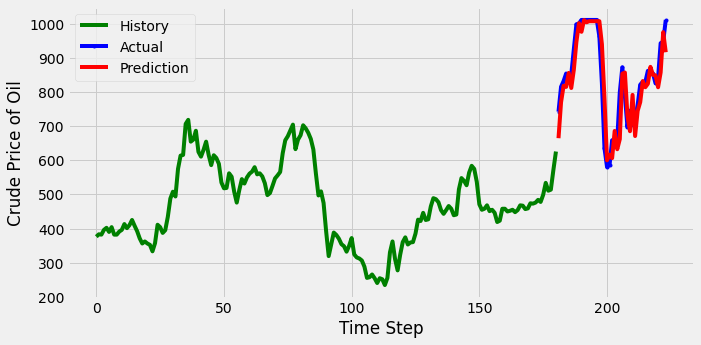

In [182]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Plot actual and predicted value

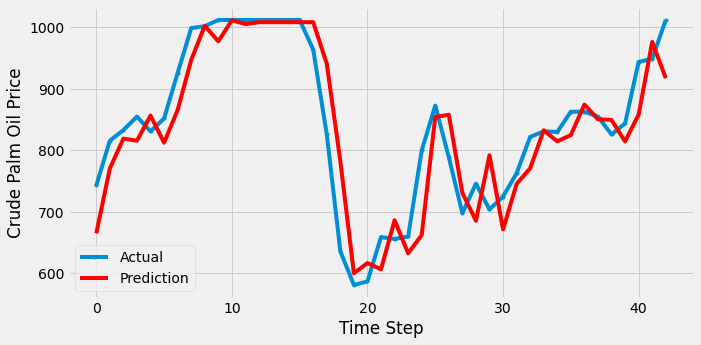

In [183]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Evaluate SVR Model Accuracy

In [185]:
MAE_mlp = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 40.38421499720725
MDA value of the SVR Model is: 0.5714285714285714
MAPE value of the SVR Model is: 5.099999660148632
RMSE value of the SVR Model is: 53.84908090217939
MSE value of the SVR Model is: 2899.723514009461
EVS score of the MLP Model is: 0.8248745757924927


In [ ]:
..updating